In [1]:
# built-in
import random
from collections import deque
from copy import deepcopy

# tihrd party
import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
# for C51
V_MAX = 10
V_MIN = -10
N_ATOMS = 51
DELTA_Z = (V_MAX - V_MIN) / (N_ATOMS - 1)

# for learning
SEED = 1
BATCH_SIZE = 256
GAMMA = 0.99
LR = 0.03
EPS = 1e-8

In [3]:
class CategoricalDuelingDQN(nn.Module):
    def __init__(self, obs_space, action_space, n_atoms):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        self.val = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_atoms)
        )

        self.adv = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, action_space * n_atoms)
        )

        self.log_softmax = nn.LogSoftmax(dim=-1)

        self.register_buffer(
            'support', torch.arange(V_MIN, V_MAX + DELTA_Z, DELTA_Z))

    def forward(self, x):
        out = self.head(x)
        val_out = self.val(out).view(out.size(0), 1, N_ATOMS)
        adv_out = self.adv(out).view(out.size(0), -1, N_ATOMS)
        adv_mean = adv_out.mean(dim=1, keepdim=True)
        out = val_out + adv_out - adv_mean
        out = self.log_softmax(out)
        probs = out.exp()

        return probs

In [4]:
losses = []


def learn(net, tgt_net, optimizer, rep_memory):
    net.train()
    tgt_net.train()

    train_data = []
    train_data.extend(random.sample(rep_memory, BATCH_SIZE))

    dataloader = DataLoader(train_data,
                            batch_size=BATCH_SIZE,
                            pin_memory=use_cuda)
    # like a double DQN
    for i, (s, a, r, _s, d) in enumerate(dataloader):
        s_batch = s.to(device).float()
        a_batch = a.to(device).long()
        _s_batch = _s.to(device).float()
        rewards = r.detach().cpu().numpy().astype(np.longlong)
        dones = d.detach().cpu().numpy().astype(np.bool)

        _p_batch = net(_s_batch)
        _weights = _p_batch * net.support
        _q_batch = _weights.sum(dim=2)
        _q_batch_np = _q_batch.detach().cpu().numpy()[0]
        _action_batch_np = np.argmax(_q_batch_np)

        with torch.no_grad():
            tgt_p_batch = tgt_net(_s_batch)
            _p_best = tgt_p_batch[range(BATCH_SIZE), _action_batch_np]
            _p_best_np = _p_best.cpu().numpy()

        proj_p_np = projection(_p_best_np, rewards, dones)
        proj_p = torch.tensor(proj_p_np).to(device).float()

        p_batch = net(s_batch)
        p_acting = p_batch[range(BATCH_SIZE), a_batch.data]

        # loss
        eps = np.finfo(np.float32).eps.item()
        loss = -(proj_p * (p_acting + eps).log()).sum(dim=1).mean()
        losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [5]:
def projection(next_p, rewards, dones):
    proj_p = np.zeros((BATCH_SIZE, N_ATOMS), dtype=np.float32)
    for atom in range(N_ATOMS):
        z = np.minimum(V_MAX, np.maximum(
            V_MIN, rewards + (V_MIN + atom * DELTA_Z) * GAMMA))
        b = (z - V_MIN) / DELTA_Z
        l = np.floor(b).astype(np.int64)
        u = np.ceil(b).astype(np.int64)

        eq_mask = u == l
        proj_p[eq_mask, l[eq_mask]] += next_p[eq_mask, atom]
        ne_mask = u != l
        proj_p[ne_mask, l[ne_mask]] += next_p[ne_mask, atom] * (u - b)[ne_mask]
        proj_p[ne_mask, u[ne_mask]] += next_p[ne_mask, atom] * (b - l)[ne_mask]

        if dones.any():
            proj_p[dones] = 0.0
            z = np.minimum(V_MAX, np.maximum(V_MIN, rewards[dones]))
            b = (z - V_MIN) / DELTA_Z
            l = np.floor(b).astype(np.int64)
            u = np.ceil(b).astype(np.int64)

            eq_mask = u == l
            eq_dones = dones.copy()
            eq_dones[dones] = eq_mask
            if eq_dones.any():
                proj_p[eq_dones, l] = 1.0

            ne_mask = u != l
            ne_dones = dones.copy()
            ne_dones[dones] = ne_mask
            if ne_dones.any():
                proj_p[ne_dones, l] = (u - b)[ne_mask]
                proj_p[ne_dones, u] = (b - l)[ne_mask]

    return proj_p

In [6]:
# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)

# make an environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
max_steps = env.spec.max_episode_steps*env.spec.timestep_limit

# hyperparameter
learn_start = env.spec.timestep_limit*5
memory_size = learn_start*20
update_frq = int(env.spec.timestep_limit/10)
epsilon = 1.
eps_min = 0.0025
eps_decay = 1. - np.exp(np.log(eps_min)/(max_steps/2))
num_eval = 10

# global values
total_steps = 0
learn_steps = 0
rewards = []
reward_eval = deque(maxlen=num_eval)
is_learned = False
is_solved = False

# make two nerual networks
net = CategoricalDuelingDQN(obs_space, action_space, N_ATOMS).to(device)
target_net = deepcopy(net)

# make optimizer
# optimizer = optim.SGD(net.parameters(), momentum=0.9, lr=LR, weight_decay=1e-4)
optimizer = optim.Adam(net.parameters(), lr=LR, eps=EPS)

# make memory
rep_memory = deque(maxlen=memory_size)

cuda: True
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


In [7]:
env.spec.max_episode_steps

200

In [8]:
env.spec.reward_threshold

195.0

In [9]:
env.spec.timestep_limit

200

In [10]:
# play
for i in range(1, env.spec.max_episode_steps+1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            target_net.eval()
            with torch.no_grad():
                state = torch.tensor([obs]).to(device).float()
                probs = target_net(state)
                weights = probs * net.support
                q = weights.sum(dim=2)
                q_np = q.cpu().numpy()[0]
                action = np.argmax(q_np)

        _obs, reward, done, _ = env.step(action)

        rep_memory.append((obs, action, reward, _obs, done))

        obs = _obs
        total_steps += 1
        ep_reward += reward
        epsilon -= epsilon * eps_decay
        epsilon = max(eps_min, epsilon)

        if len(rep_memory) >= learn_start:
            if len(rep_memory) == learn_start:
                print('\n============  Start Learning  ============\n')
            learn(net, target_net, optimizer, rep_memory)
            learn_steps += 1

        if learn_steps == update_frq:
            target_net.load_state_dict(net.state_dict())
            learn_steps = 0
    if done:
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))

        if len(reward_eval) >= num_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                break
env.close()

  1 Episode in    12 steps, reward 12.00
  2 Episode in    27 steps, reward 15.00
  3 Episode in    49 steps, reward 22.00
  4 Episode in    94 steps, reward 45.00
  5 Episode in   110 steps, reward 16.00
  6 Episode in   125 steps, reward 15.00
  7 Episode in   137 steps, reward 12.00
  8 Episode in   148 steps, reward 11.00
  9 Episode in   184 steps, reward 36.00
 10 Episode in   197 steps, reward 13.00
 11 Episode in   209 steps, reward 12.00
 12 Episode in   226 steps, reward 17.00
 13 Episode in   247 steps, reward 21.00
 14 Episode in   282 steps, reward 35.00
 15 Episode in   296 steps, reward 14.00
 16 Episode in   306 steps, reward 10.00
 17 Episode in   347 steps, reward 41.00
 18 Episode in   359 steps, reward 12.00
 19 Episode in   378 steps, reward 19.00
 20 Episode in   401 steps, reward 23.00
 21 Episode in   422 steps, reward 21.00
 22 Episode in   442 steps, reward 20.00
 23 Episode in   458 steps, reward 16.00
 24 Episode in   469 steps, reward 11.00
 25 Episode in  

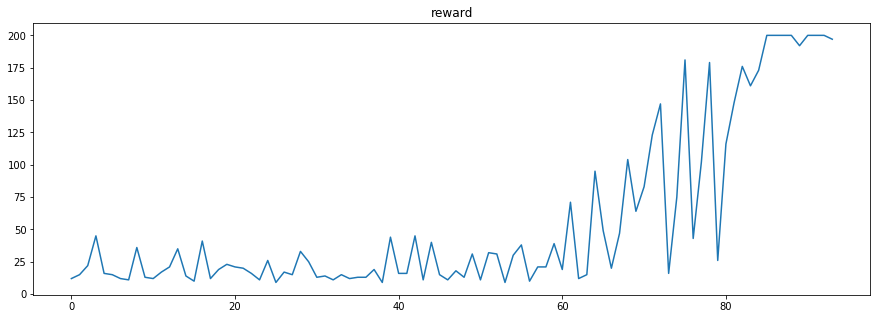

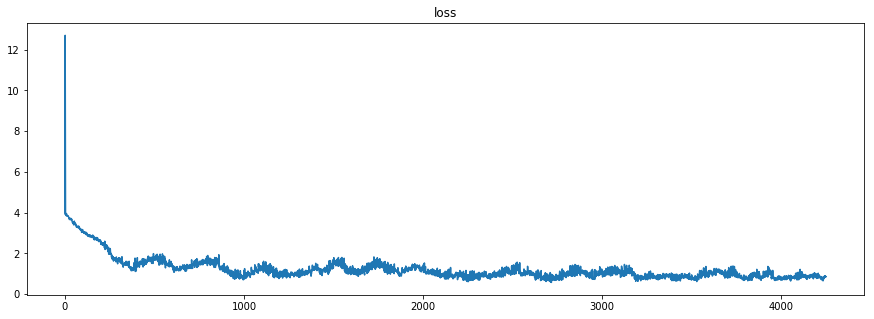

In [11]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.figure(figsize=(15, 5))
plt.title('loss')
plt.plot(losses)
plt.show()